In [122]:
import numpy as np
import classify
import warnings
import matplotlib.pyplot as plt
import matplotlib
from scipy.sparse import csr_matrix
%matplotlib inline

from sklearn import metrics
from speech import *
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression


tarfname = "data/speech.tar.gz"

In [123]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, target_names=None):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
#     tick_marks = list(np.arange(len(target_names)))
    plt.xticks(tick_marks, target_names, rotation=45, fontsize = 5)
    plt.yticks(tick_marks, target_names, fontsize = 5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def logistic_param(speech, max_iter=500, solver='lbfgs', penalty='none', C=1.0, multi_class='auto'):
    # Training
    cls = LogisticRegression(solver=solver, penalty=penalty, C=C, multi_class=multi_class)
    cls.fit(speech.trainX, speech.trainy)
    # Evaluating
    ytrp = cls.predict(speech.trainX)
    acc = metrics.accuracy_score(speech.trainy, ytrp)
    print("Training accuracy: {}".format(acc))
    ytep = cls.predict(speech.devX)
    acc = metrics.accuracy_score(speech.devy, ytep)
    f1 = metrics.f1_score(speech.devy, ytep, average='macro')
    print("Test accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
    return ytep, speech.devy

# Data Analysis

In [124]:
speech = read_files(tarfname)

-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels


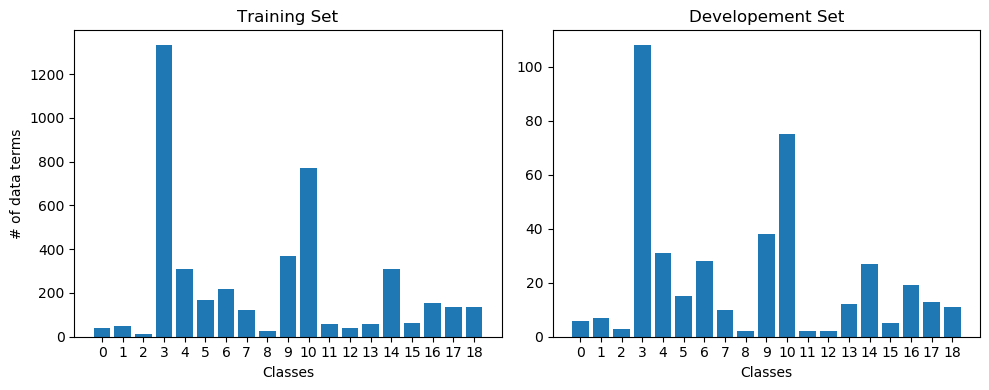

In [113]:
fig, ax = plt.subplots(1,2, dpi=100, figsize=(10,4))

l = [0]*len(set(speech.trainy))
for i, c in enumerate(set(speech.trainy)):
    l[i] = (speech.trainy == c).sum()
ax[0].bar(list(set(speech.trainy)), l, edgecolor='None', tick_label=list(set(speech.trainy)))
ax[0].set_title("Training Set")
ax[0].set_xlabel("Classes")
ax[0].set_ylabel("# of data terms")

l = [0]*len(set(speech.devy))
for i, c in enumerate(set(speech.devy)):
    l[i] = (speech.devy == c).sum()
ax[1].bar(list(set(speech.devy)), l, edgecolor='None', tick_label=list(set(speech.devy)))
ax[1].set_title("Developement Set")
ax[1].set_xlabel("Classes")

plt.tight_layout()
plt.show()

In [236]:
# speech.trainX[3163].max()
# speech.trainy[3163]
# print('\n')
# print(speech.train_data[3163].decode('utf-8'))
# print('\n')
# print(unlabeled.toarray())

# Supervised Logistic Regression + Bag of Words

## Using default settings to get the baseline

-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
Training accuracy: 0.9832951945080092
Test accuracy: 0.4082125603864734
F1-Score: 0.1830518404863846


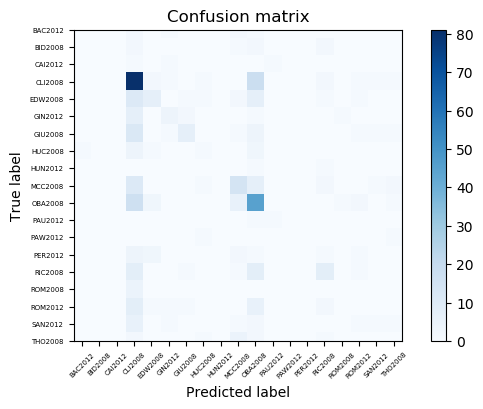

In [17]:
import warnings
warnings.filterwarnings('ignore')

def benchmark():
    speech = read_files(tarfname)
    # Training classifier
    cls = classify.train_classifier(speech.trainX, speech.trainy)
    # Evaluating
    ytrp = cls.predict(speech.trainX)
    acc = metrics.accuracy_score(speech.trainy, ytrp)
    print("Training accuracy: {}".format(acc))
    ytep = cls.predict(speech.devX)
    acc = metrics.accuracy_score(speech.devy, ytep)
    f1 = metrics.f1_score(speech.devy, ytep, average='macro')
    print("Test accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
    return ytep, speech.devy

with warnings.catch_warnings(record=True):
    warnings.warn("should not appear")
    ytep, yte = benchmark()

cm = confusion_matrix(yte, ytep)
plt.figure(dpi=100)
plot_confusion_matrix(cm, target_names=[str(x[:3]+str(x[-4:])) for x in speech.target_labels])
# plot_confusion_matrix(cm, target_names=[str(x) for x in yte])
plt.show()

It can be seen from the confusion matrix that our term matrix is dominated by class # 4 and class # 11. So that our model is keen to classify any speech as these two classes.

In [130]:
print("Ratio of CLI2008: {:.2f}; ratio of OBA2008: {:.2f}".format((yte == 3).sum() / len(yte),(yte == 10).sum() / len(yte)))

Ratio of CLI2008: 0.26; ratio of OBA2008: 0.18


## Optimization on Logistic Regression Model
1. max-iter & tol & solver
2. Penalty
3. C value

### 1. Max-iter & tol & solver
Sometime lbfgs doesn't converge if max iteration number is lower than 100. To be safe, I set it to be 500. The default tol (1e-4) is solid enough to handle the training. For the solver, lbfsg is more suitable for multi-class data than liblinear.

### 2. Penalty
As we use lbfgs, we can only consider two penalty options, 'none' and 'l2' here. (lbfgs solver only takes these two penalty options.)

In [143]:
speech = read_files(tarfname)
pen_list = ['none', 'l2']
for pen in pen_list:
    _, _ = log_param(speech, penalty=pen)

-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
Training accuracy: 1.0
Test accuracy: 0.37681159420289856
Training accuracy: 0.9835240274599543
Test accuracy: 0.4106280193236715


### 3. C value
Because C only funcions when there is penalty term, I set penalty option as 'l2' here.

In [144]:
speech = read_files(tarfname)
C_list = [0.1, 0.5, 1.0, 2.0, 10.0, 100.0]
for C in C_list:
    _, _ = log_param(speech, penalty='l2', C=C)

-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
Training accuracy: 0.6080091533180778
Test accuracy: 0.3864734299516908
Training accuracy: 0.940274599542334
Test accuracy: 0.4106280193236715
Training accuracy: 0.9835240274599543
Test accuracy: 0.4106280193236715
Training accuracy: 0.9951945080091533
Test accuracy: 0.4106280193236715
Training accuracy: 0.9995423340961098
Test accuracy: 0.3864734299516908
Training accuracy: 1.0
Test accuracy: 0.3864734299516908


## Optimization on Bag of Words
1. TF-IDF
2. ngram
3. stop words

### 1. TF-IDF
As TF-IDF is commonly used in a variaty of NLP problems and its power on balance the frequent and rare terms, I chose TF-IDF Vectorizer to extract the text features rahter than plain Count Vectorizer. However, it can be observed that with TF-IDF, the model's performance on development data became worse. 

In [9]:
speech = read_files_TFIDF(tarfname, ngram_range=(1,1))
ytep, pte = logistic_param(speech)

-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
Training accuracy: 1.0
Test accuracy: 0.3888888888888889


### 2. N-gram
I explored the performance of different 'N' settings for N-gram, also the combination of different 'N's. ngram_range = (1, 1) means using 1-gram. 

The results show that more complex combination of length of terms doesn't have to result in better performance. The decline of accuracy in (1,2) & (2,3) and (1,3) & (2,3) also tells that 1-gram contains import information in the data, which cannot be ignored or subtituted by longer term.

In [23]:
ngram_list = [(1, 1), (2, 2), (3, 3), (1, 2), (1, 3), (2, 3)]
for ngram in ngram_list:
    print("Using ngram: {}".format(ngram))
    speech = read_files_TFIDF(tarfname, ngram_range=ngram)
    ytep, pte = logistic_param(speech)

Using ngram: (1, 1)
-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
Training accuracy: 1.0
Test accuracy: 0.3888888888888889
F1-Score: 0.17851687698638657
Using ngram: (2, 2)
-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
Training accuracy: 1.0
Test accuracy: 0.2898550724637681
F1-Score: 0.1268932334933525
Using ngram: (3, 3)
-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
Training accuracy: 0.9993135011441647
Test accuracy: 0.23671497584541062
F1-Score: 0.0684624036120467
Using ngram: (1, 2)
-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
Training accuracy: 1.0
Test accuracy: 0.4251207729468599
F1-Score: 0.23036982990110805
Using ngram: (1, 3)
-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
Training accuracy: 1.0
Test accuracy: 0.4057971014492754
F1-Score: 0.18643260434973763
Using ngram: (2, 3)
-- tra

# Semi-supervised Learning

In [202]:
from scipy.sparse import coo_matrix, vstack

In [203]:
# Load Data
# speech = read_files(tarfname)
speech = read_files_TFIDF(tarfname, ngram_range=(1,2))
unlabeled = read_unlabeled(tarfname, speech)

-- train data
train.tsv
4370
-- dev data
dev.tsv
414
-- transforming data and labels
(43342, 58095)


In [204]:
def opt_train_classifier(X, y, max_iter=10000, solver='lbfgs', penalty='none', C=1.0, multi_class='auto'):
    # Training
    cls = LogisticRegression(solver=solver, penalty=penalty, C=C, multi_class=multi_class)
    cls.fit(X, y)
    
    return cls

In [205]:
# Baseline without expanding
with warnings.catch_warnings(record=True):
    warnings.warn("should not appear")
#     cls = classify.train_classifier(speech.trainX, speech.trainy)
    cls = opt_train_classifier(speech.trainX, speech.trainy)
    classify.evaluate(speech.trainX, speech.trainy, cls)
    classify.evaluate(speech.devX, speech.devy, cls)

  Accuracy 1.0
  Accuracy 0.4251207729468599


In [206]:
def expand_data(speech, unlabeled, cls):
#     ytep = cls.predict(speech.devX)
    y_extra = cls.predict(unlabeled.X)

    expanded_X = vstack([speech.trainX, unlabeled.X])
    expanded_y = np.concatenate([speech.trainy, y_extra])
    assert len(expanded_X.toarray()) == len(expanded_y)
    
    return expanded_X, expanded_y

def find_conf_ind(prob_extra, conf_thresh=0.5):
    """Only select those prediction prob larger than the confidence threshold"""
    conf = []
    
    for i, pred in enumerate(prob_extra):
        if (pred > conf_thresh).sum() > 0:
            conf.append(i)
        else:
            pass
    return list(set(conf))

def expand_data_conf(speech, unlabeled, cls, pre_include=[], conf_thresh=0.5):
    prob_extra = cls.predict_proba(unlabeled.X)
    y_extra = np.argmax(prob_extra, axis=1)
    include = find_conf_ind(prob_extra, conf_thresh=conf_thresh)
    
    include = [x for x in include if x not in pre_include]
    
    expanded_X = vstack([speech.trainX, unlabeled.X[include]])
    expanded_y = np.concatenate([speech.trainy, y_extra[include]])
    assert len(expanded_X.toarray()) == len(expanded_y)
    
    return expanded_X, expanded_y, list(set(include+pre_include)), num_of_each_label(y_extra[include])

def num_of_each_label(ypred, class_list=list(range(19))):
    class_dict = {}
    for c in class_list:
        class_dict[c] = (ypred == c).sum()
    return class_dict

### Add every prediction in each iteration

In [207]:
# exanded_num = []
expanded_classes = []
dev_acc = []
added_classes = {}

with warnings.catch_warnings(record=True):
    warnings.warn("should not appear")
    iter_total = 5
    iter_count = 0
    while True:
        # Initialize the classifier if it's the 1st iteration
        print("# {} iteration ...".format(iter_count))
        if iter_count == 0:
            cls = opt_train_classifier(speech.trainX, speech.trainy)
            for c in set(speech.trainy):
                added_classes[c] = (speech.trainy == c).sum() # actually un-expanded classes
        else:
            # Expand the data using self-training algorithm (every prediction version)
            expanded_X, expanded_y = expand_data(speech, unlabeled, cls)
            cls = opt_train_classifier(expanded_X, expanded_y)
            for c in set(expanded_y):
                added_classes[c] = (expanded_y == c).sum() # actually un-expanded classes
        
        expanded_classes.append(added_classes)
        print("Training")
        _ = classify.evaluate(expanded_X, expanded_y, cls)
        print("Development")
        acc = classify.evaluate(speech.devX, speech.devy, cls)
        dev_acc.append(acc)
    
        iter_count += 1
        if iter_count >= iter_total:
            break
        

# 0 iteration ...
Training
  Accuracy 0.9758970489604293
Development
  Accuracy 0.4251207729468599
# 1 iteration ...
Training
  Accuracy 0.9912600603621731
Development
  Accuracy 0.4251207729468599
# 2 iteration ...
Training
  Accuracy 0.9839872568745808
Development
  Accuracy 0.4251207729468599
# 3 iteration ...
Training
  Accuracy 0.9899815560026828
Development
  Accuracy 0.41304347826086957
# 4 iteration ...
Training
  Accuracy 0.9949698189134809
Development
  Accuracy 0.41304347826086957


In [197]:
speech.trainX.shape

(4370, 58095)

### with confidency threshold

__confidence threshold = 0.5__

In [234]:
# cls = opt_train_classifier(speech.trainX, speech.trainy)

# prob_extra = cls.predict_proba(unlabeled.X)

iter_total = 5
iter_count = 0
included = []

expanded_num_50 = []
expanded_classes_50 = []
dev_acc_50 = []
included = []
added_classes = {}

with warnings.catch_warnings(record=True):
    warnings.warn("should not appear")
    while True:
        # Initialize the classifier if it's the 1st iteration
        print("# {} iteration ...".format(iter_count))
        if iter_count == 0:
            cls = opt_train_classifier(speech.trainX, speech.trainy)
            for c in set(speech.trainy):
                added_classes[c] = (speech.trainy == c).sum() # actually un-expanded classes
        else:
            # Expand the data using self-training algorithm
            expanded_X, expanded_y, included, added_classes = expand_data_conf(speech, unlabeled, cls, pre_include=included, conf_thresh=0.5)
            print(len(included))

            cls = opt_train_classifier(expanded_X, expanded_y)

        expanded_num_50.append(len(included))
        expanded_classes_50.append(added_classes)
        print("Training")
        _ = classify.evaluate(expanded_X, expanded_y, cls)
        print("Development")
        acc = classify.evaluate(speech.devX, speech.devy, cls)
        dev_acc_50.append(acc)

        iter_count += 1
        if iter_count >= iter_total:
            break

# 0 iteration ...
Training
  Accuracy 0.9126527677929547
Development
  Accuracy 0.4251207729468599
# 1 iteration ...
41677
Training
  Accuracy 0.9919212978044172
Development
  Accuracy 0.42028985507246375
# 2 iteration ...
43127
Training
  Accuracy 1.0
Development
  Accuracy 0.39371980676328505
# 3 iteration ...
43328
Training
  Accuracy 1.0
Development
  Accuracy 0.40096618357487923
# 4 iteration ...
43340
Training
  Accuracy 1.0
Development
  Accuracy 0.39855072463768115


__Confident threshold = 0.75__

In [235]:
iter_total = 5
iter_count = 0
included = []

expanded_num_75 = []
expanded_classes_75 = []
dev_acc_75 = []
included = []
added_classes = {}

with warnings.catch_warnings(record=True):
    warnings.warn("should not appear")
    while True:
        # Initialize the classifier if it's the 1st iteration
        print("# {} iteration ...".format(iter_count))
        if iter_count == 0:
            cls = opt_train_classifier(speech.trainX, speech.trainy)
            for c in set(speech.trainy):
                added_classes[c] = (speech.trainy == c).sum() # actually un-expanded classes
        else:
            # Expand the data using self-training algorithm
            expanded_X, expanded_y, included, added_classes = expand_data_conf(speech, unlabeled, cls, pre_include=included, conf_thresh=0.75)
            print(len(included))

            cls = opt_train_classifier(expanded_X, expanded_y)

        expanded_num_75.append(len(included))
        expanded_classes_75.append(added_classes)
        print("Training")
        _ = classify.evaluate(expanded_X, expanded_y, cls)
        print("Development")
        acc = classify.evaluate(speech.devX, speech.devy, cls)
        dev_acc_75.append(acc)

        iter_count += 1
        if iter_count >= iter_total:
            break

training_size_75 = [expand + len(speech.trainy) for expand in expanded_num_75]

# 0 iteration ...
Training
  Accuracy 0.9981743496120493
Development
  Accuracy 0.4251207729468599
# 1 iteration ...
35633
Training
  Accuracy 0.9996250281228908
Development
  Accuracy 0.41304347826086957
# 2 iteration ...
41168
Training
  Accuracy 1.0
Development
  Accuracy 0.3719806763285024
# 3 iteration ...
43070
Training
  Accuracy 1.0
Development
  Accuracy 0.37922705314009664
# 4 iteration ...
43279
Training
  Accuracy 1.0
Development
  Accuracy 0.41304347826086957


__confidence threshold = 0.9__

In [238]:
iter_total = 5
iter_count = 0
included = []

expanded_num_90 = []
expanded_classes_90 = []
dev_acc_90 = []
included = []
added_classes = {}

with warnings.catch_warnings(record=True):
    warnings.warn("should not appear")
    while True:
        # Initialize the classifier if it's the 1st iteration
        print("# {} iteration ...".format(iter_count))
        if iter_count == 0:
            cls = opt_train_classifier(speech.trainX, speech.trainy)
            for c in set(speech.trainy):
                added_classes[c] = (speech.trainy == c).sum() # actually un-expanded classes
        else:
            # Expand the data using self-training algorithm
            expanded_X, expanded_y, included, added_classes = expand_data_conf(speech, unlabeled, cls, pre_include=included, conf_thresh=0.90)
            print(len(included))

            cls = opt_train_classifier(expanded_X, expanded_y)

        expanded_num_90.append(len(included))
        expanded_classes_90.append(added_classes)
        print("Training")
        _ = classify.evaluate(expanded_X, expanded_y, cls)
        print("Development")
        acc = classify.evaluate(speech.devX, speech.devy, cls)
        dev_acc_90.append(acc)

        iter_count += 1
        if iter_count >= iter_total:
            break

training_size_90 = [expand + len(speech.trainy) for expand in expanded_num_90]

# 0 iteration ...
Training
  Accuracy 0.9687162891046386
Development
  Accuracy 0.4251207729468599
# 1 iteration ...
30535
Training
  Accuracy 1.0
Development
  Accuracy 0.41304347826086957
# 2 iteration ...
41290
Training
  Accuracy 1.0
Development
  Accuracy 0.3961352657004831
# 3 iteration ...
42864
Training
  Accuracy 1.0
Development
  Accuracy 0.4033816425120773
# 4 iteration ...
43129
Training
  Accuracy 1.0
Development
  Accuracy 0.4033816425120773


__confidence threshold = 0.99__

In [239]:
iter_total = 5
iter_count = 0
included = []

expanded_num_99 = []
expanded_classes_99 = []
dev_acc_99 = []
included = []
added_classes = {}

with warnings.catch_warnings(record=True):
    warnings.warn("should not appear")
    while True:
        # Initialize the classifier if it's the 1st iteration
        print("# {} iteration ...".format(iter_count))
        if iter_count == 0:
            cls = opt_train_classifier(speech.trainX, speech.trainy)
            for c in set(speech.trainy):
                added_classes[c] = (speech.trainy == c).sum() # actually un-expanded classes
        else:
            # Expand the data using self-training algorithm
            expanded_X, expanded_y, included, added_classes = expand_data_conf(speech, unlabeled, cls, pre_include=included, conf_thresh=0.99)
            print(len(included))

            cls = opt_train_classifier(expanded_X, expanded_y)

        expanded_num_99.append(len(included))
        expanded_classes_99.append(added_classes)
        print("Training")
        _ = classify.evaluate(expanded_X, expanded_y, cls)
        print("Development")
        acc = classify.evaluate(speech.devX, speech.devy, cls)
        dev_acc_99.append(acc)

        iter_count += 1
        if iter_count >= iter_total:
            break

training_size_99 = [expand + len(speech.trainy) for expand in expanded_num_99]

# 0 iteration ...
Training
  Accuracy 0.9687162891046386
Development
  Accuracy 0.4251207729468599
# 1 iteration ...
21926
Training
  Accuracy 1.0
Development
  Accuracy 0.4178743961352657
# 2 iteration ...
38619
Training
  Accuracy 1.0
Development
  Accuracy 0.41304347826086957
# 3 iteration ...
39616
Training
  Accuracy 1.0
Development
  Accuracy 0.4033816425120773
# 4 iteration ...
40810
Training
  Accuracy 1.0
Development
  Accuracy 0.4033816425120773


## Plots for Semi-supervised

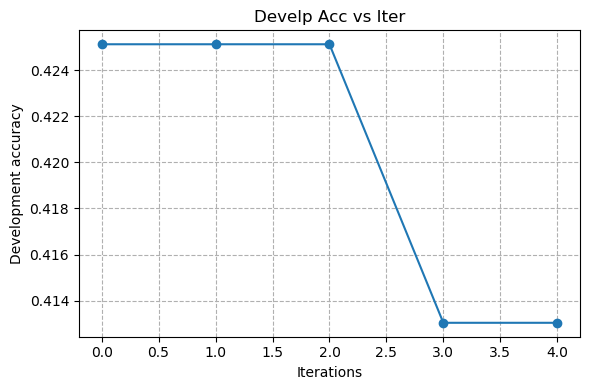

In [210]:
# training_size_90 = []
# expanded_classes_90 = [{}]
# dev_acc_90 = []


fig, ax = plt.subplots(1,1, dpi=100)
ax.set_title("Develp Acc vs Iter")
ax.set_xlabel("Iterations")
ax.set_ylabel("Development accuracy")
ax.plot(list(range(len(dev_acc))), dev_acc, marker='o', label='0.50')
# ax.plot(expanded_num, dev_acc, marker='o')
ax.set_xscale('linear')

plt.grid(ls='--')
# plt.legend()
plt.tight_layout()
plt.show()

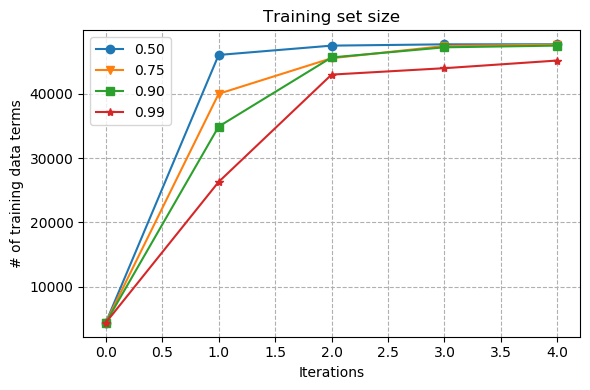

In [62]:
fig, ax = plt.subplots(1,1, dpi=100)
ax.set_title("Training set size")
ax.set_xlabel("Iterations")
ax.set_ylabel("# of training data terms")

ax.plot(list(range(len(training_size_50))), training_size_50, marker='o', label='0.50')
ax.plot(list(range(len(training_size_75))), training_size_75, marker='v', label='0.75')
ax.plot(list(range(len(training_size_90))), training_size_90, marker='s', label='0.90')
ax.plot(list(range(len(training_size_99))), training_size_99, marker='*', label='0.99')
plt.grid(ls='--')
plt.legend()
plt.tight_layout()
plt.show()

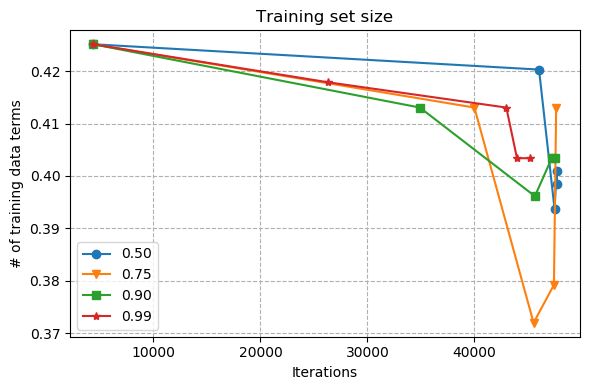

In [231]:
fig, ax = plt.subplots(1,1, dpi=100)
ax.set_title("Training set size")
ax.set_xlabel("Iterations")
ax.set_ylabel("# of training data terms")

# ax.plot(list(range(len(dev_acc_50))), dev_acc_50, marker='o', label='0.50')
# ax.plot(list(range(len(dev_acc_75))), dev_acc_75, marker='v', label='0.75')
# ax.plot(list(range(len(dev_acc_90))), dev_acc_90, marker='s', label='0.90')
# ax.plot(list(range(len(dev_acc_99))), dev_acc_99, marker='*', label='0.99')

ax.plot(training_size_50, dev_acc_50, marker='o', label='0.50')
ax.plot(training_size_75, dev_acc_75, marker='v', label='0.75')
ax.plot(training_size_90, dev_acc_90, marker='s', label='0.90')
ax.plot(training_size_99, dev_acc_99, marker='*', label='0.99')

ax.set_xscale('linear')

plt.grid(ls='--')
plt.legend()
plt.tight_layout()
plt.show()

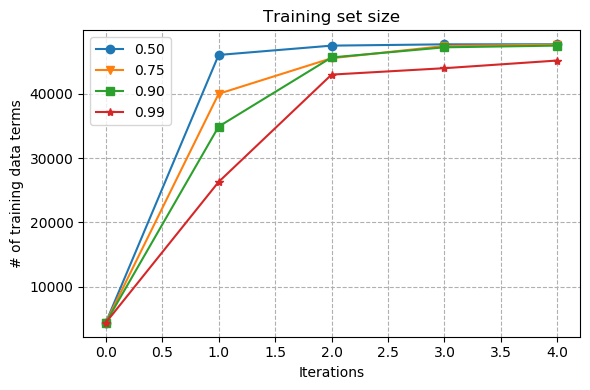

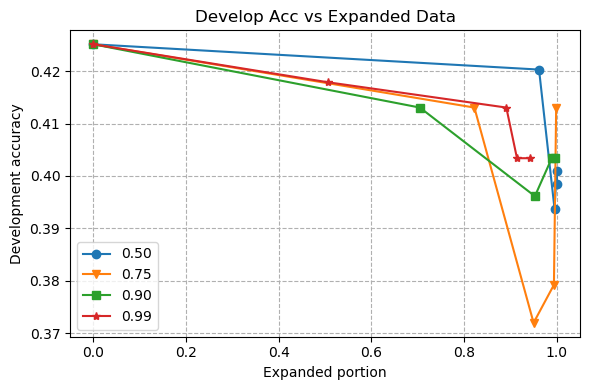

[0, 41677, 43127, 43328, 43340]


In [233]:
fig, ax = plt.subplots(1,1, dpi=100)
ax.set_title("Training set size")
ax.set_xlabel("Iterations")
ax.set_ylabel("# of training data terms")

ax.plot(list(range(len(training_size_50))), training_size_50, marker='o', label='0.50')
ax.plot(list(range(len(training_size_75))), training_size_75, marker='v', label='0.75')
ax.plot(list(range(len(training_size_90))), training_size_90, marker='s', label='0.90')
ax.plot(list(range(len(training_size_99))), training_size_99, marker='*', label='0.99')
plt.grid(ls='--')
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,1, dpi=100)
ax.set_title("Develop Acc vs Expanded Data")
ax.set_xlabel("Expanded portion")
ax.set_ylabel("Development accuracy")

# ax.plot(list(range(len(dev_acc_50))), dev_acc_50, marker='o', label='0.50')
# ax.plot(list(range(len(dev_acc_75))), dev_acc_75, marker='v', label='0.75')
# ax.plot(list(range(len(dev_acc_90))), dev_acc_90, marker='s', label='0.90')
# ax.plot(list(range(len(dev_acc_99))), dev_acc_99, marker='*', label='0.99')

ax.plot([exp_num/float(unlabeled.X.shape[0]) for exp_num in expanded_num_50], dev_acc_50, marker='o', label='0.50')
ax.plot([exp_num/float(unlabeled.X.shape[0]) for exp_num in expanded_num_75], dev_acc_75, marker='v', label='0.75')
ax.plot([exp_num/float(unlabeled.X.shape[0]) for exp_num in expanded_num_90], dev_acc_90, marker='s', label='0.90')
ax.plot([exp_num/float(unlabeled.X.shape[0]) for exp_num in expanded_num_99], dev_acc_99, marker='*', label='0.99')



plt.grid(ls='--')
plt.legend()
plt.tight_layout()
plt.show()

print(expanded_num_50)

### Choose the optimal semi-supervised model to generate predictions for Kaggle

In [71]:
iter_total = 2
iter_count = 0
included = []

with warnings.catch_warnings(record=True):
    warnings.warn("should not appear")
    while True:
        # Initialize the classifier if it's the 1st iteration
        print("# {} iteration ...".format(iter_count))
        if iter_count == 0:
            cls = opt_train_classifier(speech.trainX, speech.trainy)

        else:
            # Expand the data using self-training algorithm
            expanded_X, expanded_y, included, added_classes = expand_data_conf(speech, unlabeled, cls, pre_include=included, conf_thresh=0.99)
            print(len(included))

            cls = opt_train_classifier(expanded_X, expanded_y)

        print("Training")
        _ = classify.evaluate(expanded_X, expanded_y, cls)
        print("Development")
        acc = classify.evaluate(speech.devX, speech.devy, cls)
        dev_acc_99.append(acc)

        iter_count += 1
        if iter_count >= iter_total:
            break

write_pred_kaggle_file(unlabeled, cls, "data/speech-pred.csv", speech)

# Summarize so-far observations
## Tfidf
Using plain CountVectorizer, it is super easy to overfit to the training data. And development accuracy doesn't improve much with respect to different hyper-paramter settings.
Using TfidfVectorizer, the logistic regression model is hard to overfit on the training data (with penalty term). Give the best performance when setting penalty of logistic regression as 'none'.
## ngram
(1,2) gives the best development accuracy. (1,1) or (1,3) doesn't work as well as (1,2). 